In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import shelve
import torch
import numpy as np
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from scipy.fft import rfft, rfftfreq


def inverse_logit_transform(data, order=1):
    out = 1 + 1 / np.exp(data)
    out = np.power(out, -1 / order)
    return out

/home/wcx/multiresolution_forecasting/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Original code

In [ ]:
pth = "results/extrap_1-20230704-1710-solete_wind"
# pth = "results/extrap_1-20230704-1724-solete_solar"
seed = 0
with open(f"{pth}-{seed}.pkl", "rb") as f:
    result = pickle.load(f)
    train_mean = result["train_mean"].cpu().numpy()
    train_std = result["train_std"].cpu().numpy()
    # model = result["LSTM"]
    model = result["Neural Laplace"]
    # model = result["MLP"]
    # train_label = result["train_trajs"]
    # train_preds = result["train_preds"]
    test_rmse = model["test rmse"]
    test_label = model["test_trajs"]
    test_preds = model["test_preds"]
    val_label = model["val_trajs"]
    val_preds = model["val_preds"]
    train_losses = model["train_losses"]
    val_losses = model["val_losses"]
    model_state = model["model_state_dict"]
    test_label = test_label * train_std + train_mean
    test_preds = test_preds * train_std + train_mean
    print(test_preds.shape)
    print(test_label.shape)
    print(val_losses.shape)
    print(train_mean)
    print(train_std)
    num = 0
    for p in model_state:
        num += model_state[p].numel()
    print(num)

Loss curve

In [ ]:
num = min([len(test_preds), 9])
choose_feature = -1
fig, axs = plt.subplots(int(num / 3), 3, figsize=(3 * 2.5, (int(num / 3)) * 2))
axs = axs.flatten()
np.random.seed(7)
choose = np.random.permutation(len(test_preds))
for i in range(len(axs)):
    p, l = test_preds[choose[i]], test_label[choose[i]]
    axs[i].plot(range(len(l)), l[:, choose_feature])
    axs[i].plot(range(len(l) - len(p), len(l)), p[:, choose_feature])
    # axs[i].plot(range(len(l) - len(p), len(l)), p[:, choose_feature] - l[-len(p):, choose_feature])
    # axs[i].plot(l[:, 0]-p[:, 0],ls="--")

    # axs[i].plot(range(len(p), len(l)), p[:, -1])
fig.tight_layout()

time_steps = test_preds.shape[1]
rmse = mean_squared_error(test_label[:, -time_steps:,
                                     choose_feature].flatten(),
                          test_preds[:, -time_steps:,
                                     choose_feature].flatten(),
                          squared=False)
print(rmse)

# Performance Comparison

Overall

In [12]:
model_names = ["Neural Laplace", "LSTM", "MLP", "Persistence"]
df_results = []
choose_feature = [-1]
pth = "results/observe_528-solete-solar-False"
# pth = "results/observe_528-solete-solar-True"
# pth = "results/observe_528-solete-wind-False"
# pth = "results/observe_528-solete-wind-True"
for i in range(5):
    with open(f"{pth}-{i}.pkl", "rb") as f:
        result = pickle.load(f)
        train_mean = result["train_mean"].cpu().numpy()
        train_std = result["train_std"].cpu().numpy()
    for j in model_names:
        r = result[j]
        test_preds = r["test_preds"] * train_std + train_mean
        test_preds = test_preds[..., choose_feature]
        # test_preds = r["test_preds"][...,
        #                              choose_feature] * train_std + train_mean

        test_label = r["test_trajs"] * train_std + train_mean
        test_label = test_label[:, -test_preds.shape[1]:, choose_feature]
        # test_label = r["test_trajs"][:, -test_preds.shape[1]:,
        #                              choose_feature] * train_std + train_mean
        if pth.__contains__("True"):
            test_preds = inverse_logit_transform(test_preds)
            test_label = inverse_logit_transform(test_label)

        df_results.append({
            "method":
            j,
            "seed":
            i,
            "RMSE":
            mean_squared_error(test_label.flatten(),
                               test_preds.flatten(),
                               squared=False)
        })
df_results = pd.DataFrame(df_results)
# print(df_results)
test_rmse_df = df_results.groupby(['method']).agg(['mean',
                                                           'std'])['RMSE']
print(test_rmse_df)


                    mean       std
method                            
LSTM            0.101749  0.004906
MLP             0.106645  0.001182
Neural Laplace  0.100485  0.002467
Persistence     0.164392  0.000000


On different steps

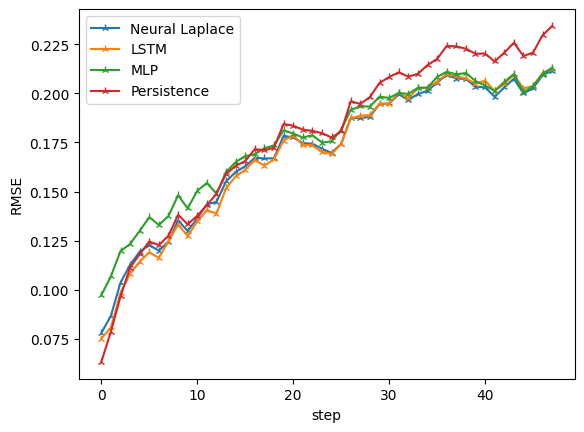

In [10]:
model_names = ["Neural Laplace", "LSTM", "MLP", "Persistence"]
df_results = []
choose_feature = [-1]
# pth = "results/observe_528-solete-solar-False"
# pth = "results/observe_528-solete-solar-True"
pth = "results/observe_528-solete-wind-False"
# pth = "results/observe_528-solete-wind-True"
for i in range(5):
    with open(f"{pth}-{i}.pkl", "rb") as f:
        result = pickle.load(f)
        train_mean = result["train_mean"].cpu().numpy()
        train_std = result["train_std"].cpu().numpy()
    for j in model_names:
        r = result[j]
        test_preds = r["test_preds"] * train_std + train_mean
        test_preds = test_preds[..., choose_feature]
        # test_preds = r["test_preds"][...,
        #                              choose_feature] * train_std + train_mean

        test_label = r["test_trajs"] * train_std + train_mean
        test_label = test_label[:, -test_preds.shape[1]:, choose_feature]
        # test_label = r["test_trajs"][:, -test_preds.shape[1]:,
        #                              choose_feature] * train_std + train_mean
        if pth.__contains__("True"):
            test_preds = inverse_logit_transform(test_preds)
            test_label = inverse_logit_transform(test_label)
        for k in range(test_preds.shape[1]):
            df_results.append({
                "method":
                j,
                "seed":
                i,
                "step":
                k,
                "RMSE":
                mean_squared_error(test_label[:, k, :].flatten(),
                                   test_preds[:, k, :].flatten(),
                                   squared=False)
            })
df_results = pd.DataFrame(df_results)
# print(df_results)
test_rmse_df = df_results.groupby(['method', 'step']).agg(['mean',
                                                           'std'])['RMSE']
fig, ax = plt.subplots()
for m in model_names:
    model_multistep_pfmce = test_rmse_df.loc[m]
    ax.plot(model_multistep_pfmce.index.tolist(),
            model_multistep_pfmce["mean"],
            label=m,
            marker="2")
    ax.set(xlabel="step", ylabel="RMSE")
    ax.legend()

# Time domain and Freq domain

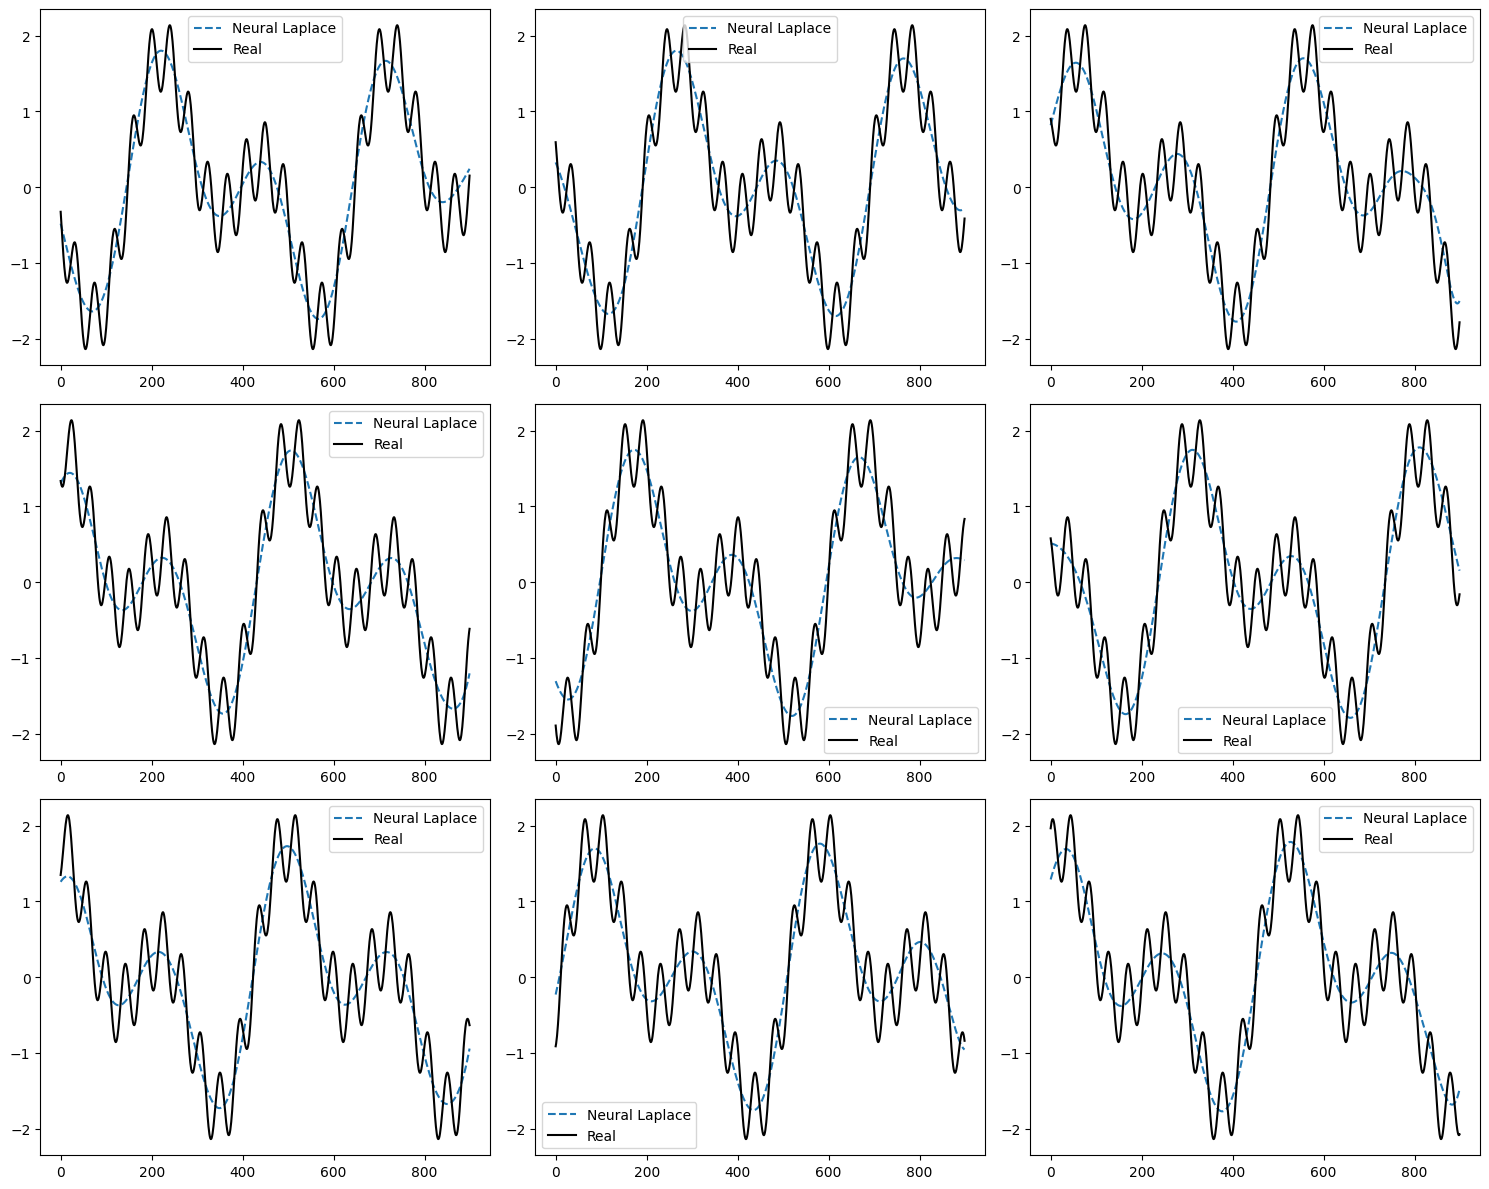

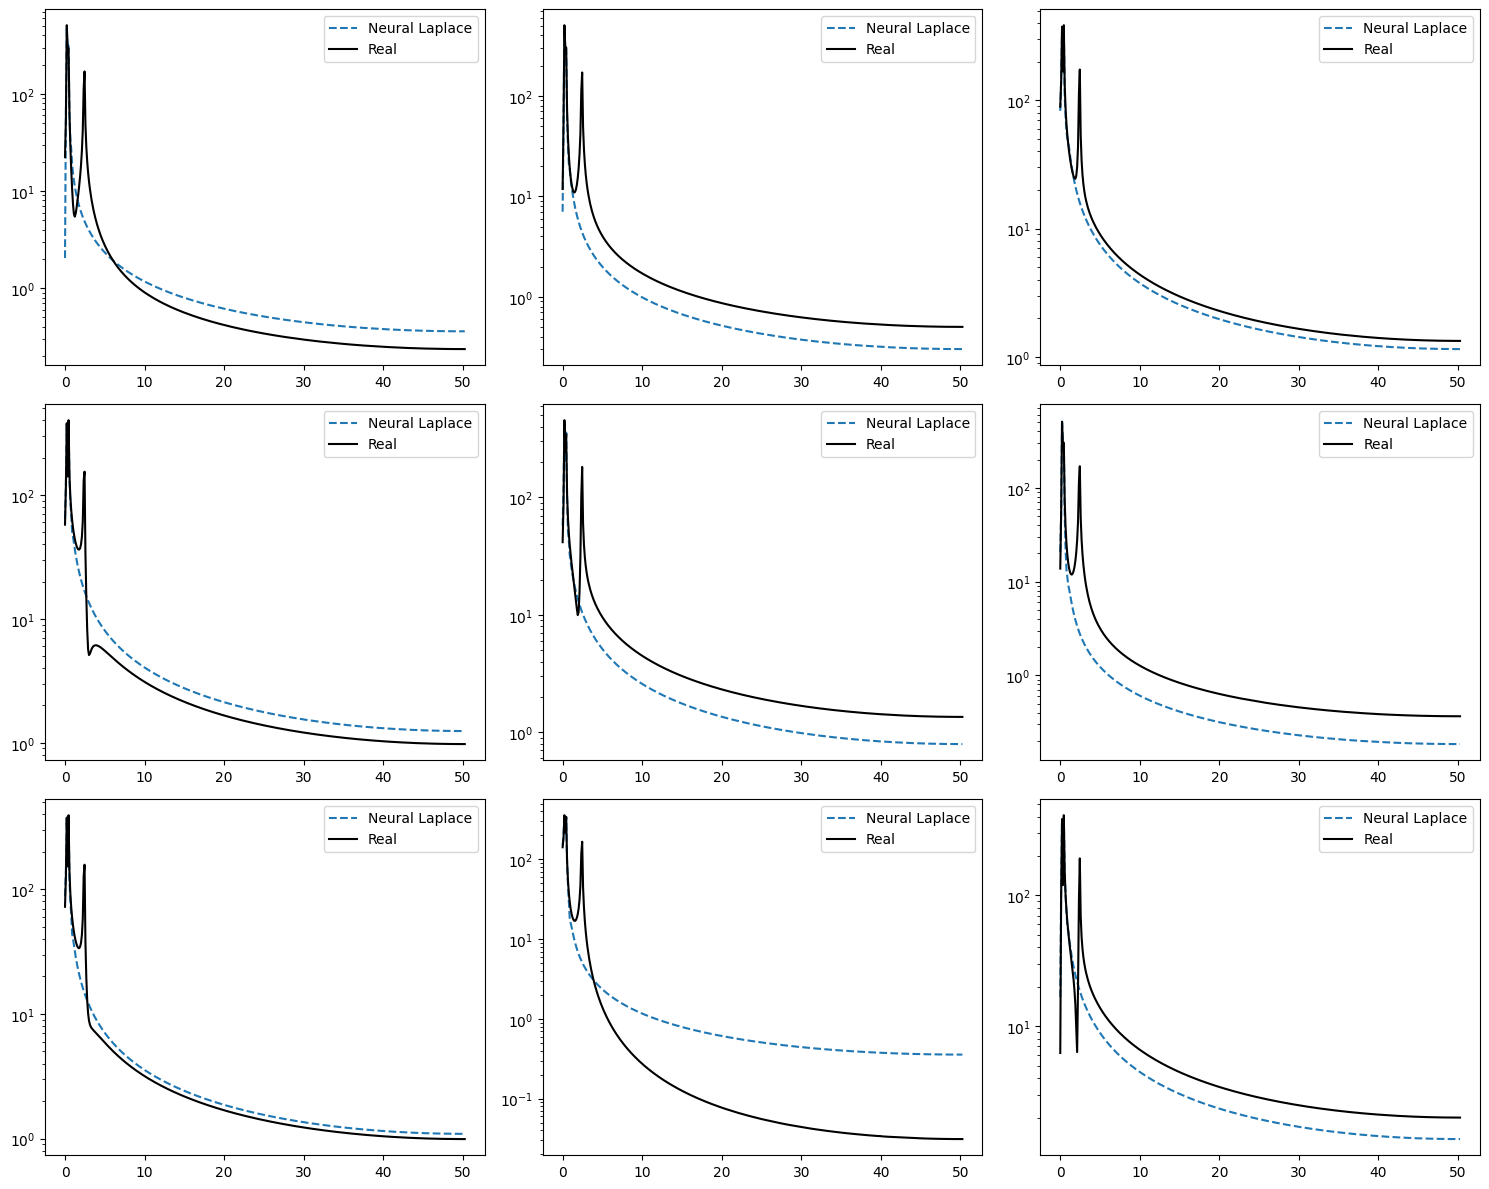

In [47]:
# model_names = ["Neural Laplace", "GRU", "MLP"]
model_names = ["Neural Laplace"]
# model_names = ["Neural Laplace", "LSTM", "MLP", "Persistence"]
df_results = []
choose_feature = -1
seed = 0


# REAL WORD DATA
# pth = "results/observe_528-solete-solar-False"
# pth = "results/observe_528-solete-solar-True"
# pth = "results/observe_528-solete-wind-False"
# pth = "results/observe_528-solete-wind-True"

# SINE WAVE
pth = "results/large-observe_100-sine-solar-False"
# pth = "results/smallILTstep-observe_100-sine-solar-False"


with open(f"{pth}-{seed}.pkl", "rb") as f:
    result = pickle.load(f)
    train_mean = result["train_mean"].cpu().numpy()
    train_std = result["train_std"].cpu().numpy()
    num_testsamples = result["Neural Laplace"]["test_preds"].shape[0]
    time_steps = result["Neural Laplace"]["test_preds"].shape[1]

num = 9
SAMPLE_RATE = 15.99547166752717 * 2 * np.pi  # Hertz
choose_feature = -1
fig, axs = plt.subplots(int(num / 3), 3, figsize=(3 * 5, (int(num / 3)) * 4))
fig2, axs2 = plt.subplots(int(num / 3), 3, figsize=(3 * 5, (int(num / 3)) * 4))
axs = axs.flatten()
axs2 = axs2.flatten()
np.random.seed(7)
choose = np.random.permutation(num_testsamples)
for i in range(len(axs)):
    for j in model_names:
        r = result[j]
        test_preds = r["test_preds"] * train_std + train_mean
        test_label = r["test_trajs"] * train_std + train_mean
        if pth.__contains__("True"):
            test_preds = inverse_logit_transform(test_preds[...,
                                                            choose_feature])
            test_label = inverse_logit_transform(test_label[...,
                                                            choose_feature])
        else:
            test_preds = test_preds[..., choose_feature]
            test_label = test_label[..., choose_feature]

        p, l = test_preds[choose[i]], test_label[choose[i]]

        # axs[i].plot(range(len(l)-len(p),len(l)),p, label=j, ls="--")
        axs[i].plot(p, label=j, ls="--")

        yf_p = rfft(p)
        xf_p = rfftfreq(len(p), 1 / SAMPLE_RATE)
        axs2[i].plot(xf_p, np.abs(yf_p), label=j, ls="--")
    # axs[i].plot(range(len(l)), l,label="Real")
    axs[i].plot(l[-time_steps:], label="Real", c="k")
    yf_l = rfft(l[-time_steps:])
    xf_l = rfftfreq(len(l[-time_steps:]), 1 / SAMPLE_RATE)
    axs2[i].plot(xf_l, np.abs(yf_l), label="Real", c="k")
    axs[i].legend()
    axs2[i].legend()
    axs2[i].set_yscale('log')
fig.tight_layout()
fig2.tight_layout()


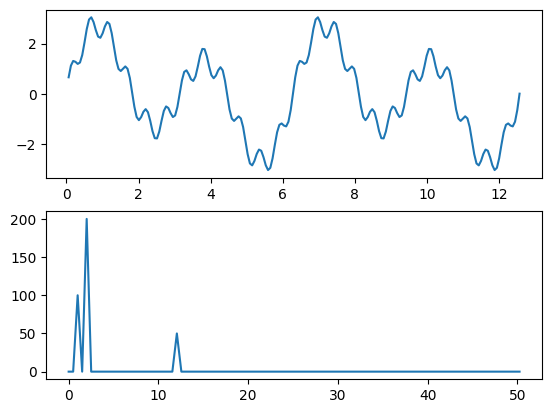

In [46]:
# num_pi=4
# t_nsamples_ref = 2000
# t_nsamples = int(t_nsamples_ref / 4 * num_pi)

t_end = 4*np.pi
t_nsamples = 200
t_begin = t_end/t_nsamples

ti = np.linspace(t_begin, t_end, t_nsamples)
SAMPLE_RATE = t_nsamples/(t_end-t_begin) * (2*np.pi)

y = np.sin(ti) +2*np.sin(2*ti) + 0.5*np.sin(12*ti)

yf = rfft(y)
xf = rfftfreq(len(y), 1 / SAMPLE_RATE)
fig, axs = plt.subplots(2)
axs[0].plot(ti, y)
axs[1].plot(xf, np.abs(yf))